In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.vision import *

In [3]:
path = Path('images/Exp1/task/')

In [4]:
def get_y_fn(x):
    return x.parent.parent.parent/'labels'/x.name.replace("tif","gif")

In [5]:
data = (SegmentationItemList.from_folder(path)
        .split_by_rand_pct()
        .label_from_func(get_y_fn, classes=['BG', 'FG'])
        .transform(get_transforms(), tfm_y=True, size=128)
        .databunch(bs=4, path=path)
        .normalize())

/home/c.marzahl@de.eu.local/ProgProjekte/fastai_v1/fastai/fastai/vision/transform.py:235: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/home/c.marzahl@de.eu.local/ProgProjekte/fastai_v1/fastai/fastai/vision/transform.py:235: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/home/c.marzahl@de.eu.local/ProgProjekte/fastai_v1/fastai/fastai/vision/transform.py:235: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/home/c.marzahl@de.eu.local/ProgProjekte/fastai_v1/fastai/fastai/vision/transform.py:235: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instea

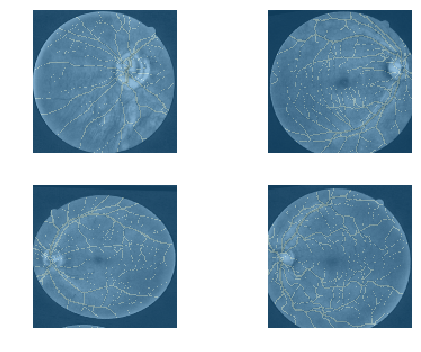

In [6]:
data.show_batch(rows=2, figsize=(7,5))

In [6]:
learn = unet_learner(data, models.resnet18, metrics=[])

In [7]:
lr_find(learn)
learn.recorder.plot()

/home/c.marzahl@de.eu.local/ProgProjekte/fastai_v1/fastai/fastai/vision/transform.py:235: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/home/c.marzahl@de.eu.local/ProgProjekte/fastai_v1/fastai/fastai/vision/transform.py:235: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/home/c.marzahl@de.eu.local/ProgProjekte/fastai_v1/fastai/fastai/vision/transform.py:235: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/home/c.marzahl@de.eu.local/ProgProjekte/fastai_v1/fastai/fastai/vision/transform.py:235: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instea

RuntimeError: CUDA error: device-side assert triggered

In [8]:
import torch
torch.cuda.is_available()

True

In [10]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [11]:
z = torch.zeros(100,10).cuda()

RuntimeError: CUDA error: device-side assert triggered